# Compare heat exchanger usage to channels 1 to 4




In [26]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn")
import numpy as np
import matplotlib.dates as mdates
from scipy import optimize
import matplotlib.patches as patches
from collections import defaultdict
from datetime import timedelta
from datetime import datetime
import pickle
from copy import deepcopy#, copy
import statistics
#from random import randrange
from bokeh.io import export_png, export_svgs
from bokeh.models import ColumnDataSource, DataTable, TableColumn
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly
import plotly.express as px
import kaleido

from my_func_mvw.functions_import_my_database import import_my_database_pickle, import_my_database_csv, merge_data_year
from my_func_mvw.functions import find_nearest_date, watertank_shift, calc_diff_between_channels, read_pickle, write_pickle, temp_watertank_func, check_first_last_date, calc_stat_of_difference, cut_dataframe_to_range_tlogger, check_processed_data, carpet_plot_with_gaps, add_nan_val_in_datagaps, statistic_plot, plot_water_rise, diff_to_watertank, create_mask_egrt
%load_ext autoreload
%autoreload 2

plot_save=True #True False

path_to_my_database = r"..\Alsdorf\Daten\my_database" #".\\"
importer = "pickle" #at the moment everything is imported with pickle

print("Some Version information of the imported packages")
print(f"pandas version: {pd.__version__}")
print(f"pickle version: {pickle.format_version}")
# pandas version: 1.2.3
# pickle version: 4.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Some Version information of the imported packages
pandas version: 1.3.2
pickle version: 4.0


In [2]:
# Load pickle Data
#if using all data this variable is over 2Gb.
data_ch14_constshifted = read_pickle(path_to_my_database + "\..\my_database_additional_local\data_ch1-4_processed_constshifted")

# final shaft temp old cable
shaft={}
for chan in ["1","2","3","4"]:
    shaft[chan] = read_pickle(path_to_my_database + f"\\shaft_final_temperature\\old_cable\\pickle\\Schacht_chan_{chan}")

# final shaft temp egrt cabel
filename=f"\\Schacht_7and8_down"
path_to_my_database_pickle = path_to_my_database + r"\shaft_final_temperature\egrt_cable\pickle"
Schacht_7and8_down = read_pickle(path_to_my_database_pickle + filename)

In [59]:
# Import heat exchanger operating monitoring
# sek: heating in building (warmer)
# prim: heat exchanger (colder)

# older version of the data
xl_file = pd.ExcelFile(path_to_my_database + "\wärmepumpe_betrieb\WP_2018-1019.xlsx")

df_wp_flow = pd.read_excel(xl_file, sheet_name="WP Durchfluss")
df_wp_flow.index=pd.to_datetime(df_wp_flow["Zeitstempel"])
df_wp_flow.sort_index(inplace=True)
df_wp_flow = df_wp_flow.drop(["Zeitstempel","WP_WMZ_sek_Flow"], axis=1)

df_wp_temp = pd.read_excel(xl_file, sheet_name="WP Temperaturen")
df_wp_temp.index=pd.to_datetime(df_wp_temp["Zeitstempel"])
df_wp_temp = df_wp_temp.drop(["Zeitstempel","WP_VL_Temp_Heizseite","WP_RL_Temp_Heizseite"],axis=1)
df_wp_temp.sort_index(inplace=True)
# difference of in and out temperature
# an estimation of how much heat is extracted
df_wp_temp["Difference_VL-RL"] = df_wp_temp["WP_VL_Temp_Soleseite"] - df_wp_temp["WP_RL_Temp_Soleseite"]


# newer version of the data
# some dates at beginning are skipped, therfore more at the end compared to other one
# created by Daniel, he created this from the raw data on sciebo. Archiv, Hree, Probebetrieb
df_wp_daniel=pd.read_csv(path_to_my_database + "\wärmepumpe_betrieb\WP-Data_2019_02-2019_06_Rohdaten.csv",delimiter=";",index_col=[0]) #dtype already is float
df_wp_daniel.index=pd.to_datetime(df_wp_daniel.index)
df_wp_daniel=df_wp_daniel.sort_index()
df_wp_daniel


,WP_VL_Temp_Soleseite,WP_RL_Temp_Soleseite,WP_WMZ_prim_Flow
Zeitstempel,,,
2019-01-03 00:05:00,23.62,23.41,1.57
2019-01-03 00:20:00,23.57,20.32,12.30
2019-01-03 00:35:00,23.70,19.84,12.33
2019-01-03 00:50:00,23.70,20.53,12.29
2019-01-03 01:05:00,23.67,20.74,12.22
...,...,...,...
2019-12-06 22:50:00,24.48,24.01,0.00
2019-12-06 23:05:00,24.49,24.02,0.00
2019-12-06 23:20:00,24.48,24.01,0.00


In [4]:
sample_hours=1
chan="3"
n_values = 15000  #number of data which is plotted from DTS, not all are needed to compare
shaft_nan={}
for c in ["1","2","3","4"]: #shorten to needed time space
    shaft_nan[c]=shaft[c][:n_values]
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan[chan])
data_dts_corr=shaft_nan_chan.resample(f"{sample_hours}H").ffill()#.diff()

temp_RL_rolling_corr = df_wp_temp["WP_RL_Temp_Soleseite"].rolling(30,min_periods=5, center = True).mean()[160000:].resample(f"{sample_hours}H").ffill()

temp_RL_rolling_corr=temp_RL_rolling_corr[110:2109]
data_dts_corr=data_dts_corr[300][1:2000]

954 dates with nan have been added


In [5]:
data_dts_corr.corr(temp_RL_rolling_corr)

0.45066481373290673

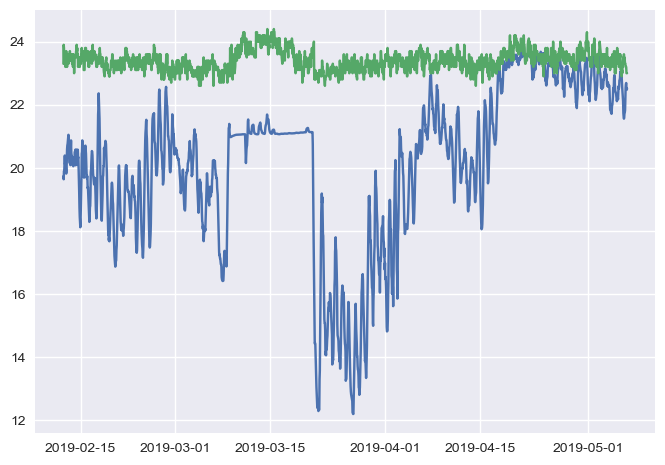

In [6]:
plt.plot(temp_RL_rolling_corr)
plt.plot(data_dts_corr)
plt.show()

954 dates with nan have been added


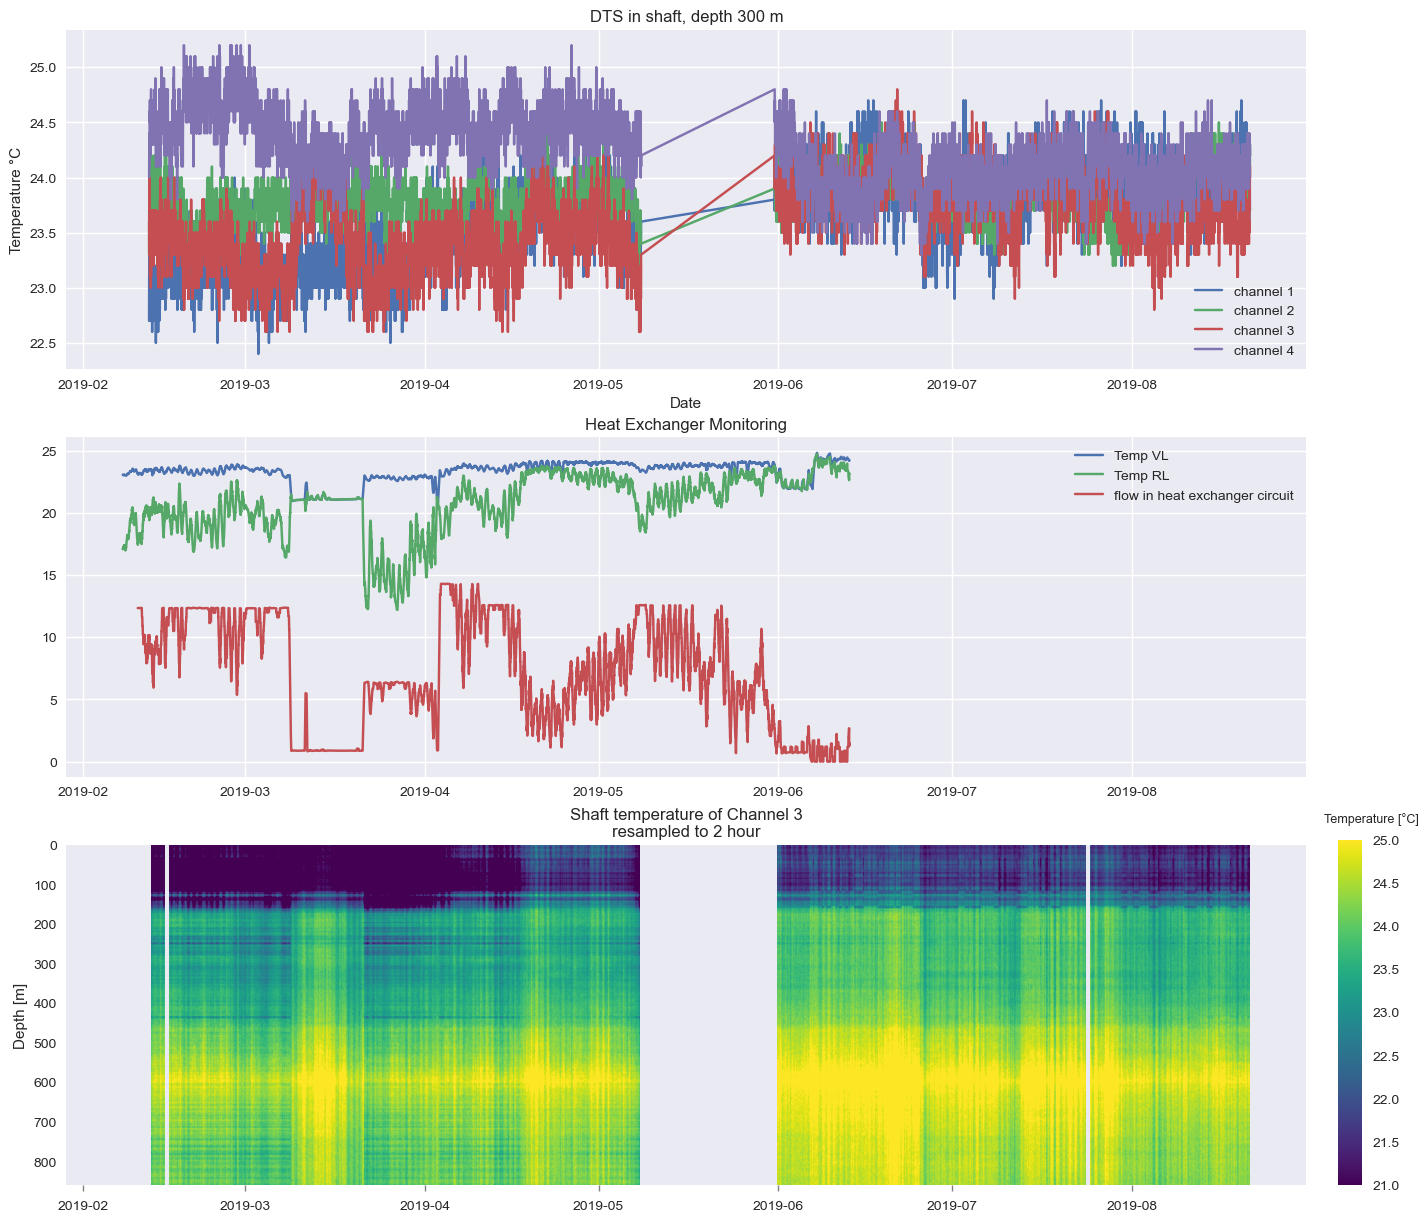

In [7]:
# plot all const shift data compared to heat exchanger monitoring
depth=300

fig, axs = plt.subplots(3,1,figsize=[16,15])

for c in ["1","2","3","4"]:
    inde=shaft[c][depth].index[:n_values]
    val=shaft[c][depth].values[:n_values]
    axs[0].plot(inde,val, label=f"channel {c}")
#axs[0].vlines(pd.to_datetime("2020-11-24 12:00:00"),22,26,color="black",label="Wireline 2020")
#axs[0].plot(df_Tlogger_PT100.index, df_Tlogger_PT100["Channel1-Watertank_PT100"], label="Watertank")

# values before 02.02.2019 are not usable --> skip first values
temp_diff_rolling=df_wp_temp["Difference_VL-RL"].rolling(30,min_periods=5, center = True).mean()[160000:]
temp_VL_rolling = df_wp_temp["WP_VL_Temp_Soleseite"].rolling(30,min_periods=5, center = True).mean()[160000:]
temp_RL_rolling = df_wp_temp["WP_RL_Temp_Soleseite"].rolling(30,min_periods=5, center = True).mean()[160000:]
flow_rolling=df_wp_flow["WP_WMZ_prim_Flow"].rolling(30,min_periods=5, center = True).mean()[29000:]
#axs[1].plot(temp_diff_rolling, label="temp diff in heat exchanger circiut")
axs[1].plot(temp_VL_rolling, label="Temp VL")
axs[1].plot(temp_RL_rolling, label="Temp RL")
axs[1].plot(flow_rolling, label="flow in heat exchanger circuit")

#axs[1].plot(temp_RL_rolling_corr)
#axs[0].plot(data_dts_corr)

axs[0].set_ylabel("Temperature °C")
axs[0].set_xlabel("Date")
axs[0].set_title(f"DTS in shaft, depth {depth} m")
axs[0].legend()
axs[1].set_title("Heat Exchanger Monitoring")
axs[1].legend()
axs[1].sharex(axs[0])

# Carpet Plot
sample_hours=2
vmin=21
vmax=25
chan="3" #change me

shaft_nan={}
n_values = 15000  #number of data which is plotted from DTS, not all are needed to compare
for c in ["1","2","3","4"]: #shorten to needed time space
    shaft_nan[c]=shaft[c][:n_values]
shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan[chan])


data=shaft_nan_chan.resample(f"{sample_hours}H").ffill()#.diff()
depth=data.columns
date = data.index.to_series()
# Datum-Ticks auf x-Achse und Farbskala
starti = depth[0]
stopi = depth[-1]
xax3 = mdates.date2num(date)
xstart = xax3[0]
xstop  = xax3[-1]

axs[2].set_title(f'Shaft temperature of Channel {chan}\nresampled to {sample_hours} hour', fontsize = 12)
axs[2].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
caxa = axs[2].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                cmap = 'viridis', aspect = 'auto', vmin = vmin, vmax = vmax)
#PiYG
axs[2].set_ylabel("Depth [m]")
axs[2].tick_params(axis="x", which='both',length=4,color="grey")
cbax = fig.add_axes([0.92, 0.11, 0.015, 0.23])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temperature [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.08)
#axs[2].sharex(axs[0])
axs[2].tick_params(axis = 'x', labelrotation = 0)
axs[2].xaxis_date()
date_format = mdates.DateFormatter('%Y-%m-%d')
axs[2].xaxis.set_major_formatter(date_format)
axs[2].sharex(axs[0])

if plot_save:
    plt.savefig("8_heat_exchanger_monitoring_compare_dts.png")
plt.show()

#kanal 3 und 4 zeigen Korreltation zu Rücklauf temperatur (entgegengesetzt)
    #3 wird wärmer bei stopp --> RL
    #4 wird kälter bei stopp --> VL

# kanal 1 und 2 zeigen kaum Änderrungen, wie Vorlauf Temperatur? 
    #Nicht so nah am Rohr, andere Seite im Kabel? die Wasser zugewnat ist?

# somit wären kanal 1 und 4 an einer glasfaser
# 2 und 3 an der anderen

# Analyse Shaft temperature during EGRT

In [8]:
# import solexperts t_logger
path_to_my_database = r"..\Alsdorf\Daten\my_database"
path_to_solexperts = path_to_my_database + "\Solexperts_EGRT"
filename = "\wagoTemperatur_korigiert.txt"
tlogger_sol = pd.read_csv(path_to_solexperts + filename, delimiter="\t", index_col=0)
tlogger_sol.columns.names = ["Dates"]
tlogger_sol.columns= pd.to_datetime(tlogger_sol.columns)
tlogger_sol.index=["Watertank"]
tlogger_sol.index.names = [""]
tlogger_sol = tlogger_sol.T
tlogger_sol.columns = ["Watertank_PT1000"] # name is does not fit to this data, just for concat woth my other dataframe

4 dates with nan have been added
4 dates with nan have been added
4 dates with nan have been added
4 dates with nan have been added


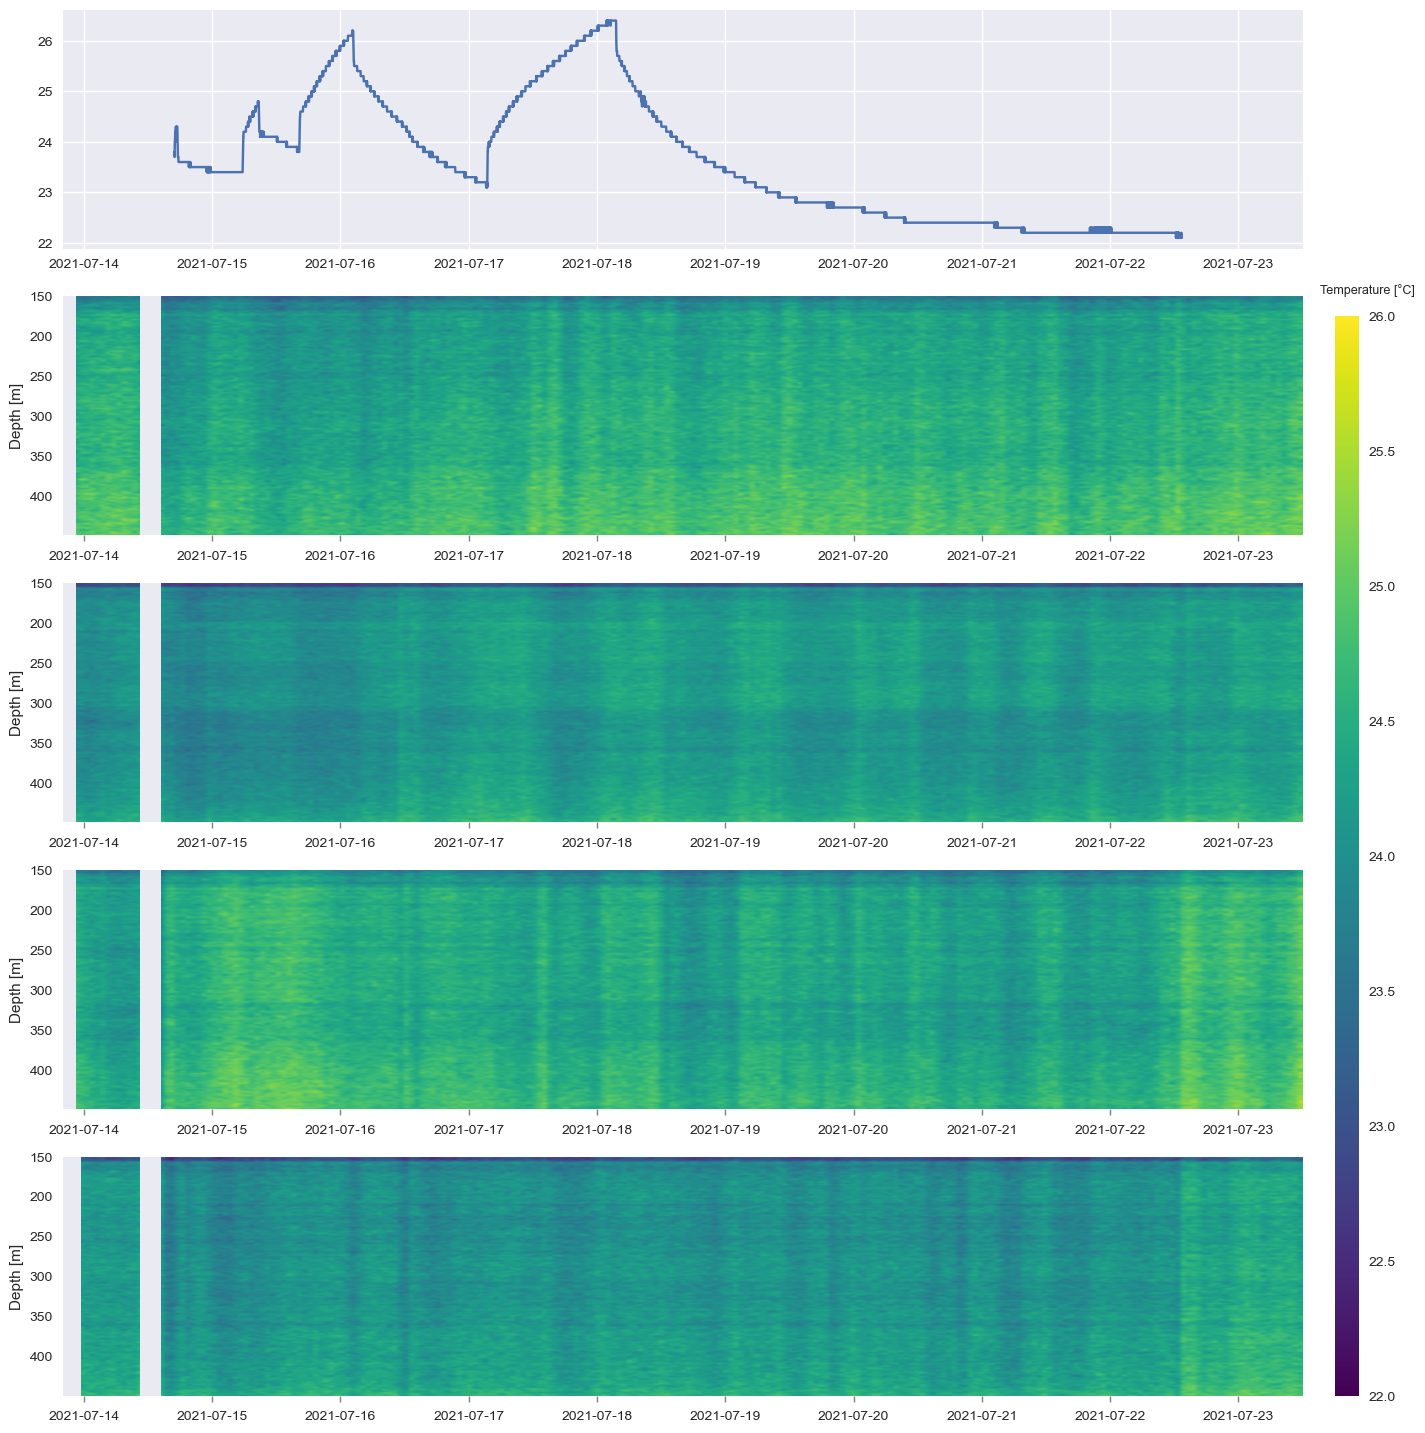

In [9]:
type_plot="normal" #normal diff
plot_where="Shaft" #Watertank Shaft
vmin=22
vmax=26
sample_hours = 1
fig, axs = plt.subplots(5,1,figsize=[16,18])

axs[0].plot(tlogger_sol["Watertank_PT1000"])
#axs[0].set_title("Watertank temperature, measured by Solexperts")

for c in ["1","2","3","4"]: #shorten to needed time space
    # in shaft hard to see influence
    if plot_where=="Shaft":
        col=shaft[c][61650:62200].columns[150:450]
        shaft_nan_chan = shaft[c][61650:62200][col]
    
    # water tank heating is visible
    if plot_where=="Watertank":
        col=data_ch14_constshifted[c][61650:62200].columns[60:100]
        shaft_nan_chan = data_ch14_constshifted[c][61650:62200][col]
    
    shaft_nan_chan = add_nan_val_in_datagaps(shaft_nan_chan)
    if type_plot=="normal":
        data=shaft_nan_chan.resample(f"{sample_hours}H").ffill()
    if type_plot=="diff":
        data=shaft_nan_chan.resample(f"{sample_hours}H").ffill().diff()
    depth=data.columns
    date = data.index.to_series()
    # Datum-Ticks auf x-Achse und Farbskala
    starti = depth[0]
    stopi = depth[-1]
    xax3 = mdates.date2num(date)
    xstart = xax3[0]
    xstop  = xax3[-1]

    #axs[int(c)].set_title(f'{plot_where} temperature of Channel {c} resampled to {sample_hours} hour', fontsize = 12)
    axs[int(c)].grid(False) #axs[0,1].grid(color = '#10366f', alpha = 0.1)
    if type_plot=="diff":
        caxa = axs[int(c)].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                        cmap = 'PiYG', aspect = 'auto', vmin = -0.3, vmax = 0.3) 
    if type_plot=="normal":
        caxa = axs[int(c)].imshow(data.transpose(), interpolation = 'gaussian', extent = [xstart, xstop, stopi, starti],
                        cmap = 'viridis', aspect = 'auto', vmin = vmin, vmax = vmax) 

    if plot_where=="Watertank":
        axs[int(c)].set_ylabel("Length [m]")
    elif plot_where=="Shaft":
        axs[int(c)].set_ylabel("Depth [m]")
    axs[int(c)].tick_params(axis="x", which='both',length=4,color="grey")
    axs[int(c)].tick_params(axis = 'x', labelrotation = 0)
    axs[int(c)].xaxis_date()
    date_format = mdates.DateFormatter('%Y-%m-%d')
    axs[int(c)].xaxis.set_major_formatter(date_format)
    axs[int(c)].sharex(axs[0])

cbax = fig.add_axes([0.92, 0.11, 0.015, 0.6])
cbar = fig.colorbar(caxa, cax = cbax, orientation = 'vertical', fraction = 0.05, pad = - 0.05)
cbar.set_label('Temperature [°C]', rotation = 0, fontsize = 9, labelpad = -20,  y = 1.03)

if plot_save:
    filename=f"\\ch14_during_egrt_carpet_{plot_where}_{type_plot}"
    plt.savefig(r".\pictures" + filename + ".png", bbox_inches="tight")
    if type_plot=="normal":
        filename=f"\\ch14_during_egrt_carpet_{plot_where}_{type_plot}.pdf"
        plt.savefig(r"..\Masterthesis_tex\appendix" + filename + ".pdf", format="pdf",bbox_inches="tight")
plt.show()

# man sieht nichts?
# statistisch analysieren, vieleicht sieht man dann was? --> Nein
# von jedem Channel min max mean stdev tiefenabhängig über diesen Zeitraum und angucken
# plots unten, man sieht auch nichts würde ich sagen

Date range at EGRT
4 dates with nan have been added


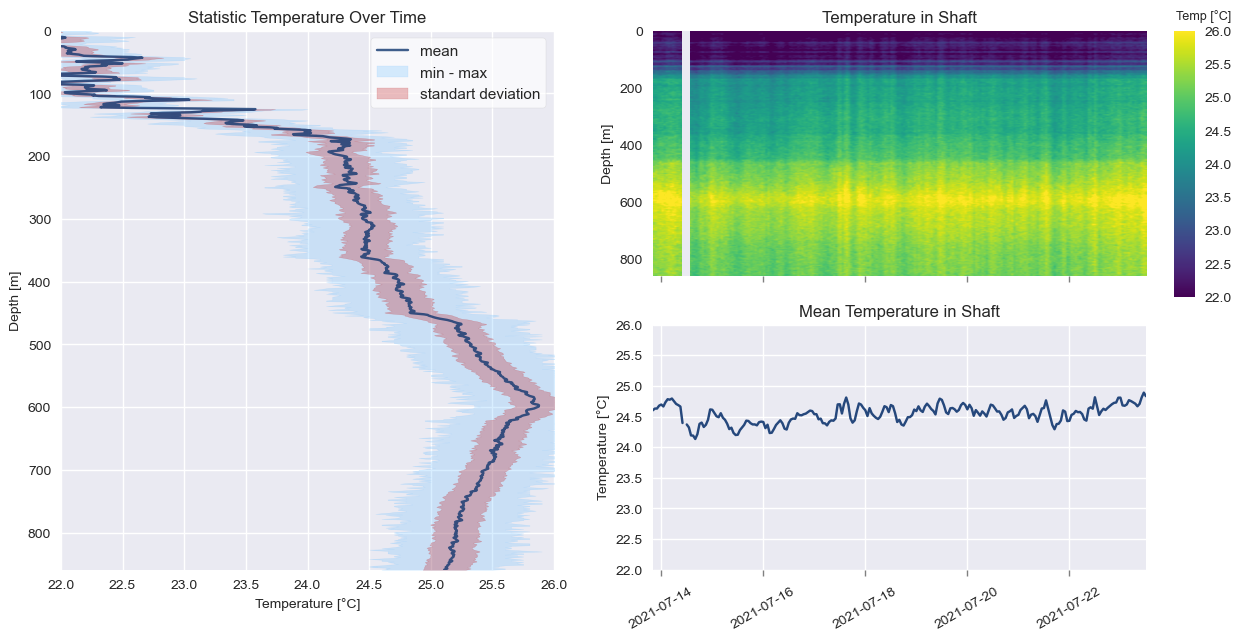

Date range before EGRT
20 dates with nan have been added


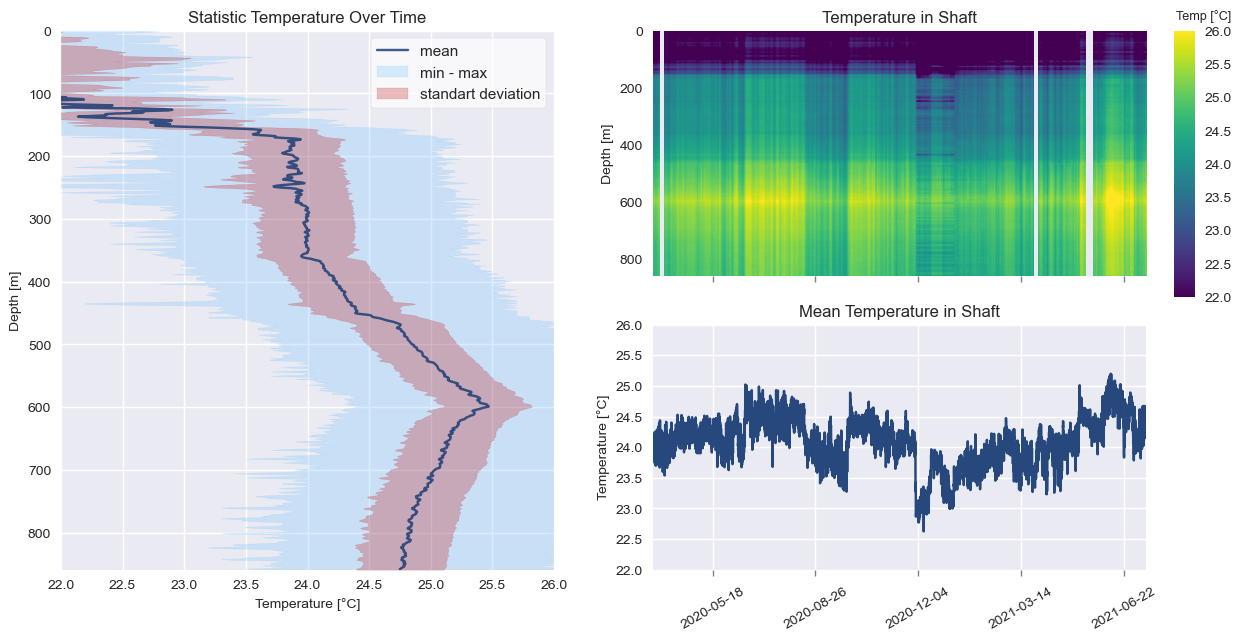

Date range after EGRT
0 dates with nan have been added


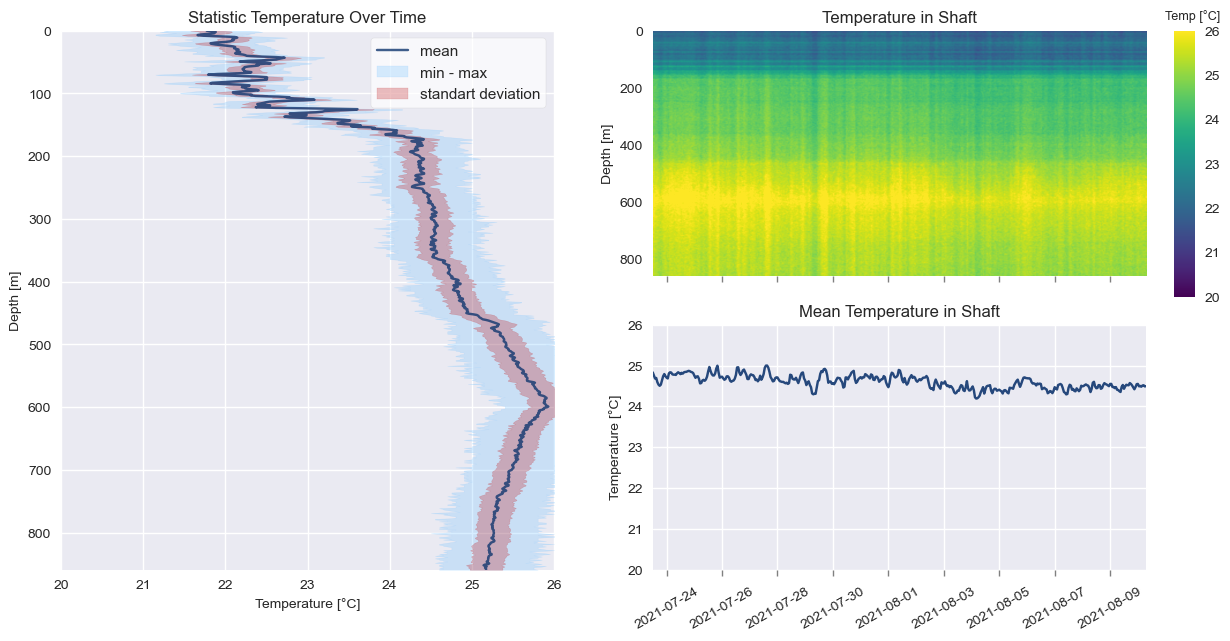

In [10]:
show_this_plots=True
if show_this_plots==True:
    # Compare: Date range at EGRT
    print("Date range at EGRT")
    statistic_plot(data_shaft=shaft)
    plt.show()

    # Compare: Date range before EGRT
    print("Date range before EGRT")
    statistic_plot(data_shaft=shaft,date_min_max=[20400,61650],c="1",temp_ax_min=22, temp_ax_max=26, sample_hours = 1)
    plt.show()

    # Compare: Date range after EGRT
    print("Date range after EGRT")
    statistic_plot(data_shaft=shaft,date_min_max=[62200,63000],c="1",temp_ax_min=20, temp_ax_max=26, sample_hours = 1)
    plt.show()

In [11]:
# Diff between channels (Vor und Rücklauf) better shows influence of hetpump
x=800
diff={}
for chan in [["1","2"],["1","3"],["1","4"],["2","3"],["2","4"],["3","4"]]:
    col=data_ch14_constshifted[chan[0]].columns[:x]
    chan1 = data_ch14_constshifted[chan[0]][col]
    col=data_ch14_constshifted[chan[1]].columns[:x]
    chan2 = data_ch14_constshifted[chan[1]][col]

    diff[f"{chan[0]} - {chan[1]}"]=chan1 - chan2.set_index(chan1.index)

#px.imshow(diff["2 - 3"][::20].transpose(),zmin=-2,zmax=5, labels={"color":"Temperature"})

In [61]:
# To DO
# ein paar plots von daniel reproduzieren





# Create new dataframe which only contains data which are also in wp dataframe
data_ch14_constshifted_dates_wp={}
for chan in ["1","2","3","4"]:
    dates_not_wp_data_mask=create_mask_egrt(data_ch14_constshifted[chan],start_date_string=df_wp_daniel.index[0],end_date_string=df_wp_daniel.index[-1])
    dates_wp_data_mask=[not elem for elem in dates_not_wp_data_mask]
    data_ch14_constshifted_dates_wp[chan]=data_ch14_constshifted[chan][dates_wp_data_mask]

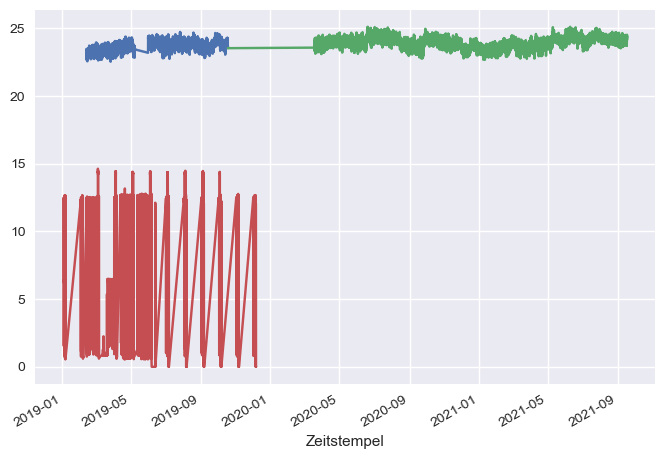

In [62]:
data_ch14_constshifted_dates_wp["1"][400].plot()
data_ch14_constshifted["1"][dates_not_wp_data_mask][400].plot()
df_wp_daniel["WP_WMZ_prim_Flow"].plot()
plt.show()

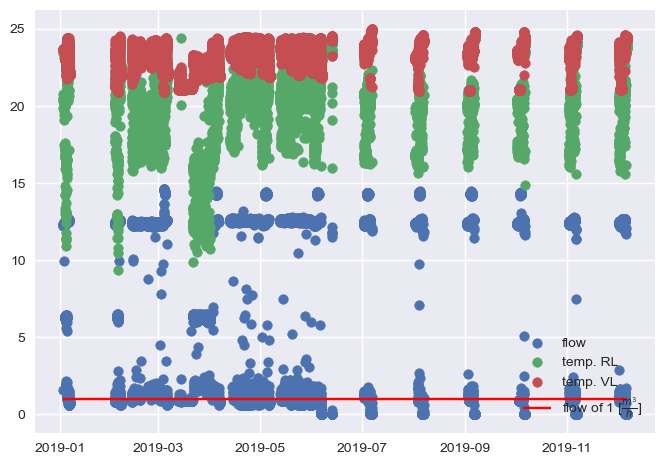

In [90]:




data_plot=df_wp_daniel["WP_WMZ_prim_Flow"]#.rolling(window="1H").mean()
plt.scatter(data_plot.index,data_plot.values,label="flow")
data_plot=df_wp_daniel["WP_RL_Temp_Soleseite"]#.rolling(window="1H").mean()
plt.scatter(data_plot.index,data_plot.values,label="temp. RL")
data_plot=df_wp_daniel["WP_VL_Temp_Soleseite"]#.rolling(window="1H").mean()
plt.scatter(data_plot.index,data_plot.values,label="temp. VL")
plt.hlines([1],df_wp_daniel["WP_WMZ_prim_Flow"].index[0],df_wp_daniel["WP_WMZ_prim_Flow"].index[-1],color="red",label=r"flow of 1 $\frac{m^3}{h}$")
#plt.ylim(0,)
plt.legend()
plt.show()

# ich sollte evntl aus den rohdaten meine eigenen Sachen raus suchen

In [110]:
# Leistungsabgriff, allerdings nicht gleich der Leistung, die der Wärmetauscher zum heizen zur Verfügung stellt
mass_flow=df_wp_daniel["WP_WMZ_prim_Flow"]  * 997.541 # [m3/h * kg/m3] = [kg/h] #Dichte bei 23 °C
temp_diff=df_wp_daniel["WP_RL_Temp_Soleseite"] - df_wp_daniel["WP_VL_Temp_Soleseite"]
energy_flow=mass_flow*temp_diff*4.190 #[kg/h * K * kJ/(kg*K)] [kJ/h]
work=energy_flow/60/60 #[kJ/s = kW]

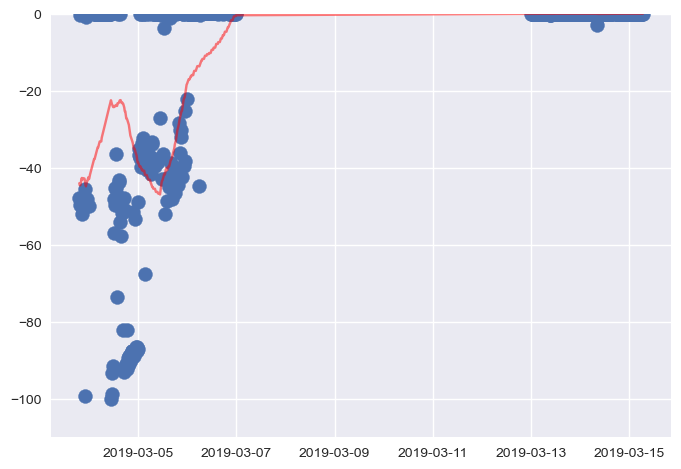

In [135]:

x=2500 #800
y=-9500 #-5000
data_plot=work.rolling(window="24H").mean()
plt.scatter(work.index[x:y],work.values[x:y],s=100)
plt.plot(data_plot.index[x:y],data_plot.values[x:y],color="red",alpha=0.5)
plt.ylim(-110,0)
plt.show()

In [104]:
temp_diff

Zeitstempel
2019-01-03 00:05:00   -0.21
2019-01-03 00:20:00   -3.25
2019-01-03 00:35:00   -3.86
2019-01-03 00:50:00   -3.17
2019-01-03 01:05:00   -2.93
                       ... 
2019-12-06 22:50:00   -0.47
2019-12-06 23:05:00   -0.47
2019-12-06 23:20:00   -0.47
2019-12-06 23:35:00   -0.47
2019-12-06 23:50:00   -0.48
Length: 12528, dtype: float64